In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall, Precision, AUC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import shutil

**Data preprocessing**


We would like to split the training dataset into two parts: training and validation.

In [3]:
data_dir = "classifier_dataset"
data_raw_dir = os.path.join(data_dir, "data_raw_dir")
train_raw_dir = os.path.join(data_raw_dir, "Training")
test_raw_dir = os.path.join(data_raw_dir, "Testing")

In [4]:
# Create new directory for splited dataset
data_pre_dir = os.path.join(data_dir, "data_pre_dir")
train_pre_dir = os.path.join(data_pre_dir, "train")
val_pre_dir = os.path.join(data_pre_dir, "validation")
test_pre_dir = os.path.join(data_pre_dir, "test")

for split_dir in [train_pre_dir, val_pre_dir, test_pre_dir]:
    if os.path.exists(split_dir):
        shutil.rmtree(split_dir) # Delete directory created on the previous run
    os.makedirs(split_dir, exist_ok=True)

In [5]:
# Copy file from raw data dir for a certain category to destination dir
def copy_files(file_list, raw_dir, dest_dir, category):
    dest_category_dir = os.path.join(dest_dir, category)
    os.makedirs(dest_category_dir, exist_ok=True)
    for file in file_list:
        raw_path = os.path.join(raw_dir, file)
        dst_path = os.path.join(dest_category_dir, file)
        shutil.copy(raw_path, dst_path)

In [6]:
categories = ["glioma", "meningioma", "pituitary", "notumor"]

for category in categories:
    train_raw_category_dir = os.path.join(train_raw_dir, category)
    test_raw_category_dir = os.path.join(test_raw_dir, category)

    if os.path.exists(train_raw_category_dir):
        image_files = os.listdir(train_raw_category_dir)

        train_category_files, val_category_files = train_test_split(
            image_files,
            test_size=0.2,
            random_state=42,
            shuffle=True
        )

        copy_files(train_category_files, train_raw_category_dir, train_pre_dir, category)
        copy_files(val_category_files, train_raw_category_dir, val_pre_dir, category)
    else:
        print(f"Training directory not found for category: {category}")

    if os.path.exists(test_raw_category_dir):
        test_category_files = os.listdir(test_raw_category_dir)
        copy_files(test_category_files, test_raw_category_dir, test_pre_dir, category)
    else:
        print(f"Testing directory not found for category: {category}")

print("Data split completed! New dataset is under:", data_pre_dir)

Data split completed! New dataset is under: classifier_dataset\data_pre_dir


In [7]:
datagen = ImageDataGenerator(rescale=1./255)

# Create generators from the split directories
train_generator = datagen.flow_from_directory(
    train_pre_dir,  # Use the training directory
    target_size=(128, 128),
    batch_size=32,color_mode='rgb',
    class_mode='categorical'
)

validation_generator = datagen.flow_from_directory(
    val_pre_dir,  # Use the validation directory
    target_size=(128, 128),
    batch_size=32,color_mode='rgb',
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_pre_dir,  # Use the test directory
    target_size=(128, 128),
    batch_size=32,color_mode='rgb',
    class_mode='categorical',
    shuffle=False # Keep order for evaluation metrics
)

Found 4568 images belonging to 4 classes.
Found 1144 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


**Build a model**

In [8]:
model = Sequential([
    # Block 1
    Conv2D(32, (5,5), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    BatchNormalization(),

    # Block 2
    Conv2D(64, (5,5), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    # Block 3
    Conv2D(128, (4,4), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    # Block 4
    Conv2D(256, (4,4), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    # Flatten and Dense Layers
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             Recall(name="recall"),
             Precision(name="precision"),
             AUC(name="auc")]
)

# Show model summary
model.summary()

e:\NUS\Project1\P2\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 13, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,351,044 (8.97 MB)

 Trainable params: 2,350,084 (8.96 MB)

 Non-trainable params: 960 (3.75 KB)

**Train the model**

In [9]:
# Early stop, monitor recall of validation, the bigger the better
early_stop = EarlyStopping(
    monitor="val_recall",
    mode="max",
    patience=3,
    restore_best_weights=True
)

# Increase weights for tumor classes (glioma, meningioma, pituitary)
# Purpose: prioritize detecting tumors over normal, to reduce missed diagnoses
class_weights = {
    0: 2.0,  # glioma
    1: 2.0,  # meningioma
    2: 1.0,  # notumor
    3: 2.0   # pituitary
}

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks = [early_stop],
    class_weight = class_weights
)

e:\NUS\Project1\P2\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 187ms/step - accuracy: 0.7463 - auc: 0.9271 - loss: 1.6963 - precision: 0.7767 - recall: 0.7204 - val_accuracy: 0.2552 - val_auc: 0.5681 - val_loss: 4.3086 - val_precision: 0.2552 - val_recall: 0.2552
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8754 - auc: 0.9808 - loss: 1.0606 - precision: 0.8863 - recall: 0.8636 - val_accuracy: 0.2587 - val_auc: 0.5603 - val_loss: 5.0227 - val_precision: 0.2574 - val_recall: 0.2570
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9275 - auc: 0.9926 - loss: 0.8331 - precision: 0.9314 - recall: 0.9238 - val_accuracy: 0.3156 - val_auc: 0.6098 - val_loss: 4.7584 - val_precision: 0.3180 - val_recall: 0.3147
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.9525 - auc: 0.9961 - loss: 0.7350 - precision: 0.9556 - recall: 0.9464 - val_accuracy: 0.6906 - val_auc: 0.9094 - val_loss: 1.3702 - val_precision: 0.6985 - val_recall: 0.6783
Epoch 5/50
143/143 ━━━━━━━

**Evaluation**

In [10]:
results = model.evaluate(test_generator)

e:\NUS\Project1\P2\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.9375 - auc: 0.9930 - loss: 0.6226 - precision: 0.9388 - recall: 0.9359


In [11]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print("Labels:", class_names)
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Confusion Matrix:
Labels: ['glioma', 'meningioma', 'notumor', 'pituitary']
[[253  40   2   5]
 [  7 273  17   9]
 [  0   0 405   0]
 [  0   2   0 298]]

Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.84      0.90       300
  meningioma       0.87      0.89      0.88       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.93      0.93      1311
weighted avg       0.94      0.94      0.94      1311



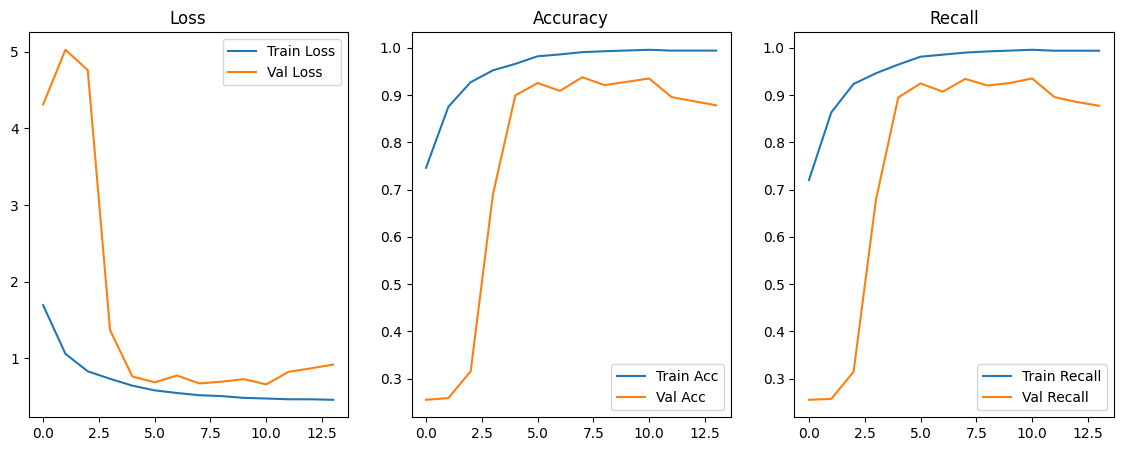

In [13]:
plt.figure(figsize=(14,5))

# Loss
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

# Accuracy
plt.subplot(1,3,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Recall
plt.subplot(1,3,3)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Val Recall')
plt.title('Recall')
plt.legend()

plt.show()


**Save the model**

In [ ]:
model.save("brain_tumor_classification_model.keras")